### Programa para el diseño de columnas rectangulares de concreto

In [1]:
# Datos a ingresar por parte del usuario *************
fc = 21.0       # f'c del concreto (En MPa)
fy = 420.0      # fy del acero (En MPa)
h = 0.98         # Ancho de la sección (En m)------Debe ser el eje débil en Biaxial
b = 0.8         # Profundidad de la sección (En m)
r = 0.135        # Recubrimiento (En m)

# Datos de uso intero del programa
beta = 0.85                                    # Ojo si f'c > 5000 psi
d = h - r
n = 100                                        # Cantidad de puntos
c = [i*(5*h - r)/n + r for i in range(n+1)]    # Distancia al eje neutro
a = []                                         # Longitud del bloque de compresión equivalente
for i in range(len(c)):
    if c[i] > h/beta:
        a.append(h)
    else:
        a.append(beta*c[i])

cuantias = [0.01, 0.02, 0.03, 0.04]
E = 210000.0                                   # Módulo de elasticidad del acero (En MPa)
epsilon_c = -0.003

# Compatibilidad de deformaciones
def_compresion = [(1 - r/i)*epsilon_c for i in c]
def_traccion = [(h/i - 1 - r/i)*(-epsilon_c) for i in c]

# Esfuerzo en el acero a compresion
esf_compresion = []
for i in range(len(def_compresion)):
    if abs(def_compresion[i]) <= (fy/E):
        esf_compresion.append(E*def_compresion[i])
    else:
        esf_compresion.append(-fy)

# Esfuerzo en el acero a tracción
esf_traccion = []
for i in range(len(def_traccion)):
    if def_traccion[i] <= (-fy/E):
        esf_traccion.append(-fy)
    elif -fy/E < def_traccion[i] < fy/E:
        esf_traccion.append(E*def_traccion[i])
    else:
        esf_traccion.append(fy)

# Definición de funciones importantes *****************
def Axial_nom(cu):
    Pn = []
    for i in range(len(c)):
        Pn.append(0.85*fc*a[i]*b - esf_compresion[i]*(cu*h*b/2) - esf_traccion[i]*(cu*h*b/2))
    return Pn  

def Mom_nom(cu):
    Mn = []
    for i in range(len(c)):
        Mn.append(0.85*fc*a[i]*b*(h/2 - a[i]/2) + (-1)*esf_compresion[i]*(cu*h*b/2)*(h/2 - r) + esf_traccion[i]*(cu*h*b/2)*(d - h/2))
    return Mn

def cargas_ultimas(Pn, Mn):
    Pu = [] ; Mu = []
    for i in range(len(c)):
        if Pn[i] >= Pn[Mn.index(max(Mn))]:
            Pu.append(0.65*Pn[i])                        # 0.65 para columnas con estribos; 0.75 para col. zunchadas
            Mu.append(0.65*Mn[i])
        else:
            if def_traccion[i] < 0.002:
                Pu.append(0.65*Pn[i])
                Mu.append(0.65*Mn[i])
            elif (0.002 <= def_traccion[i] <= 0.005):
                Pu.append((0.65 + (250/3)*(def_traccion[i] - 0.002))*Pn[i])
                Mu.append((0.65 + (250/3)*(def_traccion[i] - 0.002))*Mn[i])
            else:
                Pu.append(0.90*Pn[i])
                Mu.append(0.90*Mn[i])
    return Pu, Mu
# *****************************************************

In [2]:
# Datos para el diseño (solicitaciones)

# Solicitaciones del análisis estructural
M_max = 0.026
M_min = 0.0116
P_max = 0.0054
P_min = 0
rho = 0.025     # Cuantía de diseño

P, M = cargas_ultimas(Axial_nom(rho), Mom_nom(rho))
Pu1, Mu1 = cargas_ultimas(Axial_nom(cuantias[0]), Mom_nom(cuantias[0]))
Pu2, Mu2 = cargas_ultimas(Axial_nom(cuantias[1]), Mom_nom(cuantias[1]))
Pu3, Mu3 = cargas_ultimas(Axial_nom(cuantias[2]), Mom_nom(cuantias[2]))
Pu4, Mu4 = cargas_ultimas(Axial_nom(cuantias[3]), Mom_nom(cuantias[3]))

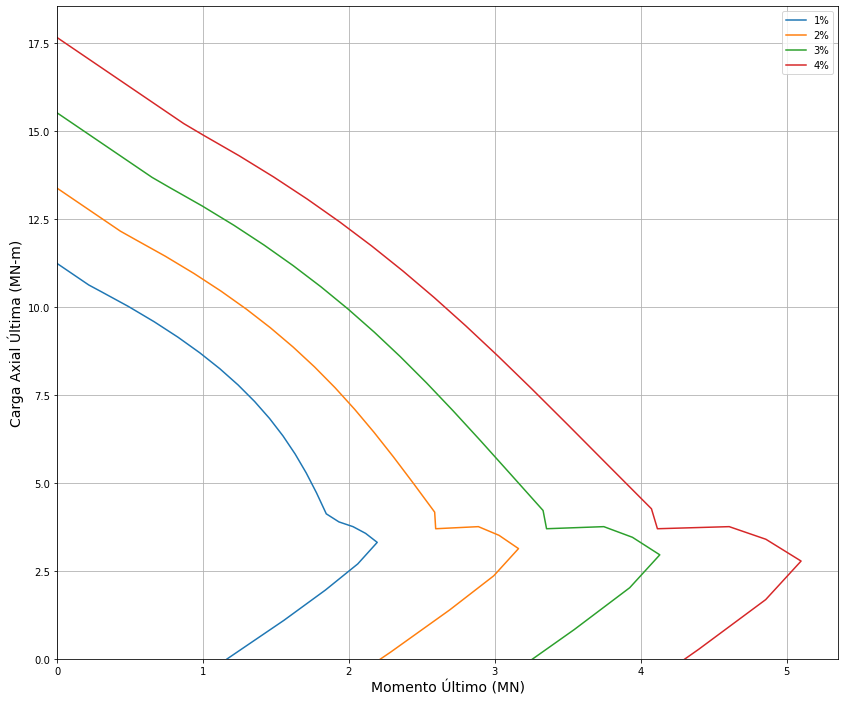

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 12))
plt.plot(Mu1, Pu1, label='1%')
plt.plot(Mu2, Pu2, label='2%')
plt.plot(Mu3, Pu3, label='3%')
plt.plot(Mu4, Pu4, label='4%')
#plt.plot(M, P, 'r--', label='Cuantía de diseño')
#plt.plot([M_min, M_max, M_max, M_min, M_min], [P_min, P_min, P_max, P_max, P_min], 'k--', label='Combinaciones posibles')
plt.legend()
plt.xlim(0, 1.05*max(Mu4))
plt.ylim(0, 1.05*max(Pu4))
plt.grid()
plt.xlabel('Momento Último (MN)', size=14)
plt.ylabel('Carga Axial Última (MN-m)', size=14)
plt.show;